In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch

Dataset size: 36718
row number 0: {'text': ''}
row number 1: {'text': ' = Valkyria Chronicles III = \n'}
row number 2: {'text': ''}
row number 3: {'text': ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n'}


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


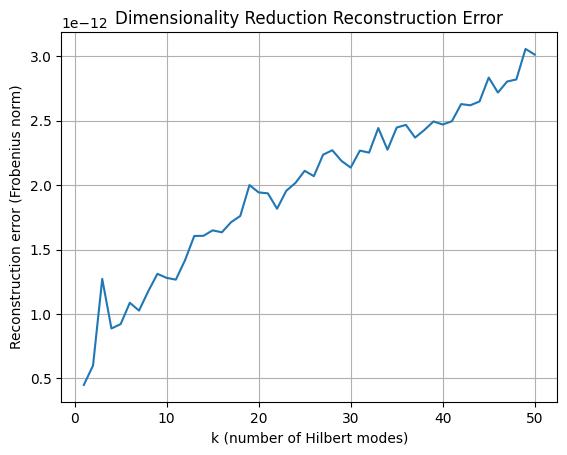

In [5]:
# ======================================================================================================================
# Experiment (2)
# Dimensionality Reduction of Language
# ======================================================================================================================

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load dataset and pretrained model/tokenizer
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")      # Load text data from the Wikitext-2 dataset.
print(f"Dataset size: {len(dataset)}")
print("row number 0:", dataset[0])
print("row number 1:", dataset[1])
print("row number 2:", dataset[2])
print("row number 3:", dataset[3])

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()                                   # Load pretrained BERT tokenizer and model (bert-base-uncased), set to evaluation mode.

texts = dataset['text'][:100]                  # Take first 100 texts
embeddings = []
with torch.no_grad():
    for text in texts:
        if not text.strip():
            continue
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)

X = np.stack(embeddings)

# D_norm = D - D.mean(axis=0, keepdims=True)

def construct_hankel_matrix(T):
    # Construct the hankel matirx Z
    Z = np.zeros((T, T))
    for i in range(T):
        for j in range(T):
            Z[i, j] = 2 / (((i + j + 2)**3) - (i + j + 2))

        # Compute eigenvalues and eigenvectors of Z
    eigvals, eigvecs = np.linalg.eigh(Z)
    pairs = sorted(zip(eigvals, eigvecs.T), key=lambda x: -x[0])
    eigvals = np.array([p[0] for p in pairs])
    eigvals = np.clip(eigvals, 1e-12, None)
    eigvecs = np.column_stack([p[1] for p in pairs])
    return eigvals, eigvecs
    

def spectral_basis(X, k, eigvals, eigvecs):
    """
    Given input stream X, computes the spectral filtered input matrix.
    
    ARGS:
        X ∈ ℝ^{T×d_in}     (inputs)
        k      : int       (Number of basis functions to use)
    Returns:
        Phi(X) ∈ ℝ^{T×k*d_in}  (filtered inputs)
    """
    T = X.shape[0]
    d_in = X.shape[1]

    # Filter inputs X and return Phi(X)
    phis = eigvecs[:, :k]  # use the first k eigenvectors
    Phi = np.zeros((T, k*d_in))
    for j in range(k):
        # causal convolution for all input dims at once
        conv = np.apply_along_axis(
            lambda x: np.convolve(x, phis[:, j], mode="full")[:T],
            axis=0,
            arr=X
        )                               # shape (T, d_in)
        Phi[:, j*d_in:(j+1)*d_in] = (eigvals[j] ** 0.25) * conv

    return Phi

eigvals, eigvecs = construct_hankel_matrix(X.shape[0])
ks = np.arange(1, 51)
errs = []
for k_i in ks:
    T_data = X.shape[0]
    Phi = spectral_basis(X, k=k_i, eigvals=eigvals, eigvecs=eigvecs)  # Generate basis with matching time dimension
    M, _, _, _ = np.linalg.lstsq(Phi, X, rcond=None)  # k_i x d # Learn an M that is kxd that projects via linear regression fit
    errs.append(np.linalg.norm(X - Phi @ M, ord='fro'))

plt.plot(ks, errs)
plt.xlabel('k (number of Hilbert modes)')
plt.ylabel('Reconstruction error (Frobenius norm)')
plt.title('Dimensionality Reduction Reconstruction Error')
plt.grid(True)
plt.show()